# Diagnosing Pneumonia from X-rays
## Introduction
In recent years, convolutional neural networks (CNNs) trained on radiological images such as x-rays have begun to outperform medical professionals in diagnosing disease. [1] Pneumonia, a serious condition where the air sacs in the lungs become filled with fluid or pus, is typically diagnosed by a chest x-ray in conjunction with other clinical measures. [2] In this notebook, I construct, train, and evaluate the performance of a CNN that predicts whether a patient has pneumonia based on a chest x-ray. I walk through the process step by step, including using Keras Tuner to tune the network hyperparameters.

In [1]:
# imports of main packages used
# submodule imports appear in the cell in which they are first used
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt  # tune Keras neural network hyperparameters
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset
The dataset is available from Kaggle. [3] It consists of 5,856 .jpeg images of chest x-rays. 1,583 of the x-rays are from healthy patients (labeled as "NORMAL") and the other 4,273 x-rays are from patients with either viral or bacterial pneumonia (labeled as "PNEUMONIA"). Here, I do not make the distinction between viral and bacterial pneumonia, and all pneumonia cases are given the label of "PNEUMONIA."

Using `ImageDataGenerator()` and its `flow_from_directory` method [4] from the `tensorflow.keras.preprocessing.image` submodule makes it simple to load image files from a directory. The file hierarchy should have one folder for each class, and within each class folder, there should be one subfolder for training images and another subfolder for test images. Although there is a "val" directory to be used for validation, it contains only 8 examples of each class. This directory was skipped and the validation set was partitioned from the training set, as shown below. Some of the training images are also slightly altered in terms of positioning (x and y values) and skew (rotation) within the frame in order to represent the possible variation in images that may exist in data not yet seen by the model.

The resources in [5-8] give additional guidance about loading data using `ImageDataGenerator`.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/'

PIXELS = 128
BATCH_SIZE = 32

# make an ImageDataGenerator to load training and validation images
# rotate and translate some of the images to add variety to the dataset
generator_train = ImageDataGenerator(validation_split=0.2,
                                     rescale=1/255.,
                                     rotation_range=5,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05)

train_ds = generator_train.flow_from_directory(
    data_dir+'train',
    target_size=(PIXELS, PIXELS),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=0
    )

val_ds = generator_train.flow_from_directory(
    data_dir+'train', # same directory as training data
    target_size=(PIXELS, PIXELS),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    color_mode='rgb',
    shuffle=True,
    seed=0
    )

generator_test = ImageDataGenerator(rescale=1/255.)

test_ds = generator_test.flow_from_directory(
    data_dir+'test',
    target_size=(PIXELS, PIXELS),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
    )

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
# setting the class_mode to 'binary' in flow_from_directory replaces the labels with 0/1 - 
# recover which value corresponds to which class
class_dict = train_ds.class_indices
print(class_dict)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [4]:
# number of examples of each class in train, validation, and test partitions
label_dict = {v: k for k, v in class_dict.items()}
datasets = {'train': train_ds, 'validation': val_ds, 'test': test_ds}

for partition, ds in datasets.items():
    counts = pd.Series(ds.classes).value_counts().sort_index()
    counts.index = counts.index.map(label_dict)
    print(partition)
    print(counts)
    print('\n')

train
NORMAL       1073
PNEUMONIA    3100
dtype: int64


validation
NORMAL       268
PNEUMONIA    775
dtype: int64


test
NORMAL       234
PNEUMONIA    390
dtype: int64




## Data Exploration
The subplots below, as used in TensorFlow's classification tutorial, [9] show some examples of x-rays from the training set.

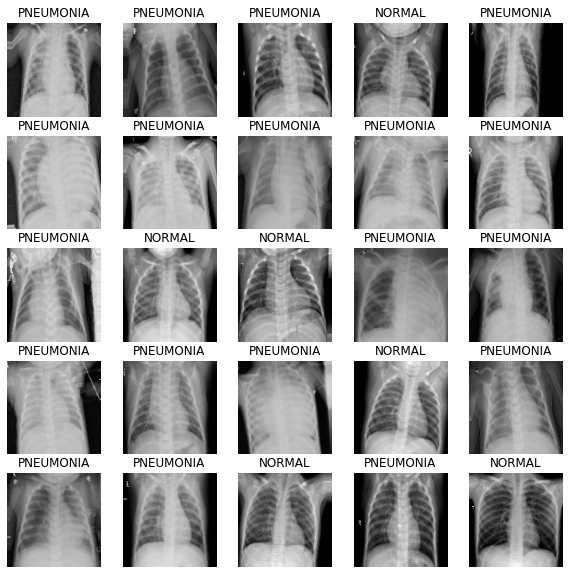

In [5]:
X_train, y_train = next(train_ds)

plt.figure(figsize=(10, 10))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    ax.set_box_aspect(1)
    
    plt.imshow(X_train[i])
    label = 'NORMAL' if int(y_train[i]) == 0 else 'PNEUMONIA'
    plt.title(label)
    plt.axis("off")

## Model Training
Keras Tuner is used to create and randomly search a search space of neural network models with varying hyperparameter values. Here, the number of neurons in each layer is varied. The resources in [10] and [11] contain some guidance about how to specify hyperparameter values using the `HyperModel` object from Keras Tuner and the documentation in [12] explains the base `Tuner` class from which specific tuners like `RandomSearch` inherit.

Keras callbacks, which run when certain conditions are met, are used for logging after each epoch [13] and for early stopping during training. Because there are nearly 3 times as many pneumonia x-rays in the training set as there are normal x-rays, class weights are applied to balance the class representation. The accuracy and area under the precision-recall curve (AUCPR) are monitored as performance metrics.

In [6]:
from keras_tuner import HyperModel
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)

LAYER_SIZE_MIN = 32
LAYER_SIZE_MAX = 64
KERNEL_SIZE_MIN = 3
KERNEL_SIZE_MAX = 5
MIN_N_LAYERS = 2
MAX_N_LAYERS = 4

class MyHyperModel(HyperModel):
    '''Neural network architecture with a search space of possible hyperparameter values.'''
    
    def build(self, hp):
        '''
        Specify network architecture and possible hyperparameter values.
        
        Args:
            hp: The definitions of the hyperparameters.
        
        Returns:
            The hypermodel.
        
        '''
        model = Sequential()
                
        for layer in range(hp.Int('layers', MIN_N_LAYERS, MAX_N_LAYERS, 1)):
            conv2d_args = {'filters': hp.Int(f'filters_{layer}',
                                 min_value=LAYER_SIZE_MIN, 
                                 max_value=LAYER_SIZE_MAX,
                                 step=32),
                           'kernel_size': hp.Int(f'kernel_{layer}',
                                 min_value=KERNEL_SIZE_MIN,
                                 max_value=KERNEL_SIZE_MAX,
                                 step=1),
                           'activation': 'relu'
                          }
            if layer == 0:
                model.add(Conv2D(**conv2d_args, input_shape=(PIXELS, PIXELS, 3)))
            else:
                model.add(Conv2D(**conv2d_args))
                
            model.add(MaxPooling2D((2, 2)))
            model.add(Dropout(0.2))

        model.add(Flatten())
        
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        
        model.compile(optimizer='RMSprop',
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=['accuracy', tf.keras.metrics.AUC(curve='PR', name='AUCPR')],
                      weighted_metrics=['accuracy', tf.keras.metrics.AUC(curve='PR', name='AUCPR')])
        
        return model

In [7]:
# balance normal vs. pneumonia classes for training
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=[0,1], y=train_ds.labels)
class_weights = dict(enumerate(class_weights))

In [8]:
class LogCallback(tf.keras.callbacks.Callback):
    '''Performance metrics saved during model training.'''
    def on_train_begin(self, logs={}):
        '''Initialize arrays to store metrics specified in logs.'''
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
    def on_epoch_end(self, epoch, logs={}):
        '''Store the specified metrics at the end of every epoch.'''
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

In [9]:
log_callback = LogCallback()
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
hypermodel = MyHyperModel()
tuner_rs = kt.RandomSearch(
            hypermodel,
            objective=kt.Objective('val_loss', direction='min'),
            seed=0,
            max_trials=1,
            executions_per_trial=1)

In [10]:
# train model using Keras Tuner or load best model from previous random search
train_model = False

if train_model:
    with tf.device('/GPU:0'):
        tuner_rs.search(train_ds,
                        epochs=10,
                        verbose=1,
                        validation_data=val_ds,
                        class_weight=class_weights,
                        callbacks=[log_callback, early_stop_callback])

    # gets the best model from the random search
    model = tuner_rs.get_best_models(1)[0]
    model.summary()

    # save best model
    model.save('model.keras')

    # view hyperparameters of best model
    tuner_rs.get_best_hyperparameters(1)[0].values
    
else:
    model = keras.models.load_model('/kaggle/input/pneumonia-model/model.keras')
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        1

## Evaluate Performance
For a medical test designed to diagnose disease, it is crucial to maximize the percentage of positive patients who are classified as positives (**recall**, or **sensitivity**), but it is also important to minimize false positives by maximizing **precision**, or **positive predictive value**. Because the CNN outputs a continuous value between 0 and 1 to represent the probability that an x-ray is from a pneumonia patient, the cutoff for a sample to be classified as pneumonia can be empirically chosen. I aim to detect at least 90% of pneumonia cases without letting an excessive number of normal x-rays get wrongly labeled as pneumonia.

In [11]:
model.evaluate(test_ds, verbose=1)

y_test = test_ds.labels

# get a value between 0 and 1 from sigmoid activation representing probability 
# that example belongs to pneumonia class
y_pred = model.predict(test_ds)

20/20 [==============================] - 13s 569ms/step - loss: 0.4554 - accuracy: 0.7724 - AUCPR: 0.9507 - weighted_accuracy: 0.7724 - weighted_AUCPR: 0.9507


[1.         0.99743587 0.99743587 0.9948718  0.99230766 0.9897436
 0.9846154  0.97692305 0.974359   0.96666664 0.96410257 0.951282
 0.94358975 0.93333334 0.9128205  0.8820513  0.8384615  0.77692306
 0.6820513 ]


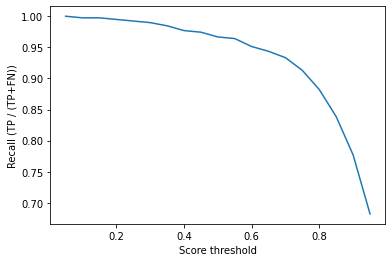

In [12]:
thresholds = np.arange(0.05,1,0.05).tolist()

# minimize false negatives = maximize recall / sensitivity (TP / (TP+FN))
m = tf.keras.metrics.Recall(thresholds=thresholds)
m.update_state(y_test,y_pred)
recall = m.result().numpy()
print(recall)

sns.lineplot(x=thresholds, y=recall)
plt.xlabel('Score threshold')
plt.ylabel('Recall (TP / (TP+FN))');

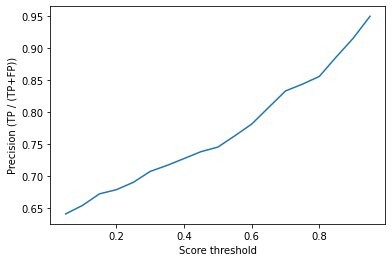

In [13]:
# maximize positive predictive value (precision)
m = tf.keras.metrics.Precision(thresholds=thresholds)
m.update_state(y_test,[x for x in y_pred])
precision = m.result().numpy()

sns.lineplot(x=thresholds, y=precision)
plt.xlabel('Score threshold')
plt.ylabel('Precision (TP / (TP+FP))');

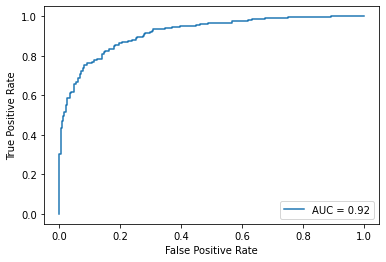

In [14]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

In [15]:
# transform to a binary prediction with empirically chosen threshold 
y_pred_binary = [1 if x > 0.75 else 0 for x in y_pred]

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77       234
           1       0.84      0.91      0.88       390

    accuracy                           0.84       624
   macro avg       0.84      0.82      0.82       624
weighted avg       0.84      0.84      0.84       624



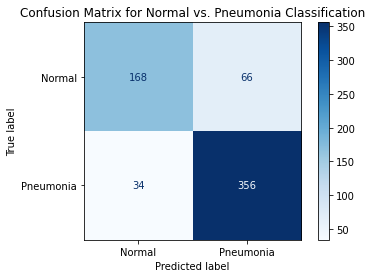

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred_binary)
ConfusionMatrixDisplay(cm, display_labels=["Normal", "Pneumonia"]).plot(cmap="Blues")
plt.title('Confusion Matrix for Normal vs. Pneumonia Classification');

0.8245442945679913


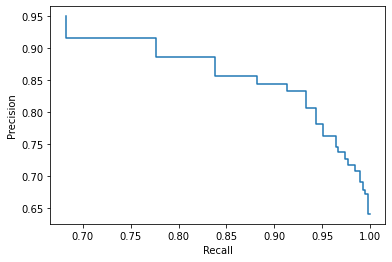

In [18]:
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay

print(average_precision_score(y_test, y_pred_binary))
PrecisionRecallDisplay(precision, recall).plot();

## Visually Inspecting Correctly vs. Incorrectly Classified Examples

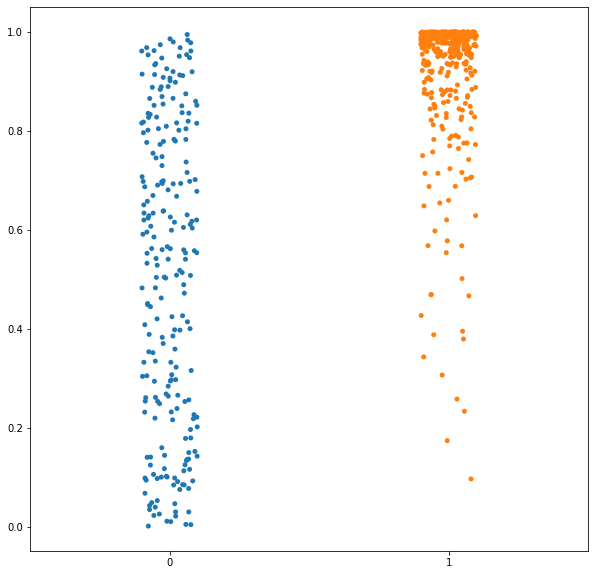

In [19]:
plt.figure(figsize=(10,10))
prob = np.array([x[0] for x in y_pred])
sns.stripplot(x=y_test, y=prob)
plt.show()

In [20]:
X_test = np.concatenate([test_ds.next()[0] for i in range(test_ds.__len__())])
n_test = X_test.shape[0]

In [28]:
def plot_xray(x, label, i):
    ax = plt.subplot(2, 5, i + 1)
    ax.set_box_aspect(1)

    plt.imshow(x)
    plt.title(label)
    plt.axis("off")

In [29]:
XRAY_PLOT_SIZE = (16, 8)
n = 5

# get indices of first n normal samples in test array that were assigned a low probability of being pneumonia
inds = np.where((prob < 0.1) & (y_test == 0))[0][:n]
normal_low_pneumonia = X_test[inds]

# get indices of first n normal samples in test array that were assigned a high probability of being pneumonia
inds = np.where((prob > 0.9) & (y_test == 0))[0][:n]
normal_high_pneumonia = X_test[inds]

# get indices of first n pneumonia samples in test array that were assigned a low probability of being pneumonia
inds = np.where((prob < 0.4) & (y_test == 1))[0][:n]
pneumonia_low_pneumonia = X_test[inds]

# get indices of first n pneumonia samples in test array that were assigned a high probability of being pneumonia
inds = np.where((prob > 0.9) & (y_test == 1))[0][:n]
pneumonia_high_pneumonia = X_test[inds]

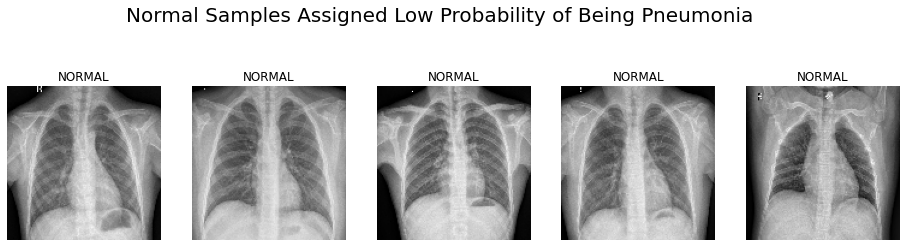

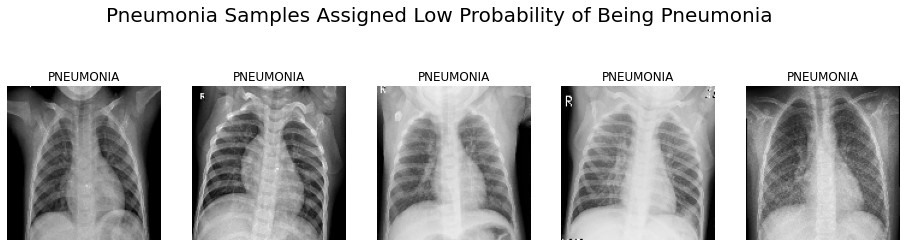

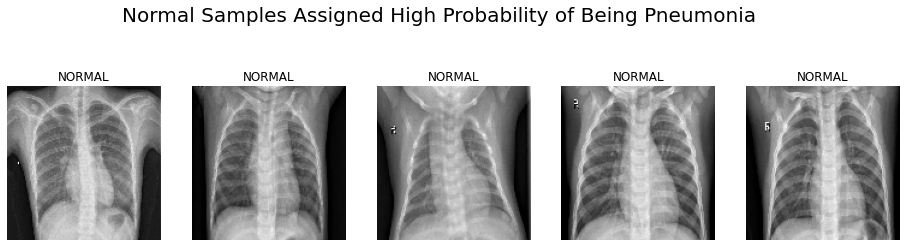

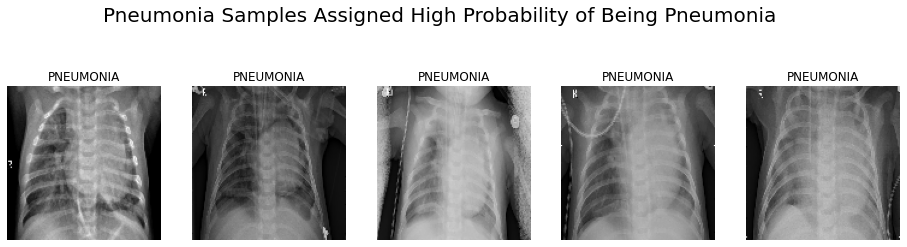

In [32]:
# examples assigned low probability of being pneumonia
fig = plt.figure(figsize=XRAY_PLOT_SIZE)
for i, x in enumerate(normal_low_pneumonia):
    plot_xray(x, 'NORMAL', i)
fig.suptitle('Normal Samples Assigned Low Probability of Being Pneumonia', fontsize=20);

fig = plt.figure(figsize=XRAY_PLOT_SIZE)
for i, x in enumerate(pneumonia_low_pneumonia):
    plot_xray(x, 'PNEUMONIA', i)
fig.suptitle('Pneumonia Samples Assigned Low Probability of Being Pneumonia', fontsize=20);

# examples assigned high probability of being pneumonia
fig = plt.figure(figsize=XRAY_PLOT_SIZE)
for i, x in enumerate(normal_high_pneumonia):
    plot_xray(x, 'NORMAL', i)
fig.suptitle('Normal Samples Assigned High Probability of Being Pneumonia', fontsize=20);

fig = plt.figure(figsize=XRAY_PLOT_SIZE)
for i, x in enumerate(pneumonia_high_pneumonia):
    plot_xray(x, 'PNEUMONIA', i)
fig.suptitle('Pneumonia Samples Assigned High Probability of Being Pneumonia', fontsize=20);

In [40]:
# TODO:
# put x-ray subplot in 2 x 2 subplot
# graph aesthetics
# summarize performance
# make citations link to webpage
# give description of resources used
# increase size of layers and number of epochs

## Citations
[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8112196/ \
[2] https://www.nhlbi.nih.gov/health/pneumonia \
[3] https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia \
[4] 
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory \
[5] https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator \
[6] https://datascience.stackexchange.com/questions/113449/what-does-shuffle-and-seed-parameter-in-keras-image-gen-flow-from-directory-si \
[7] https://www.tensorflow.org/tutorials/load_data/images \
[8] https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720 \
[9] https://www.tensorflow.org/tutorials/keras/classification \
[10] https://pythonprogramming.net/keras-tuner-optimizing-neural-network-tutorial/ \
[11] https://towardsdatascience.com/hyperparameter-tuning-with-keras-tuner-283474fbfbe \
[12] https://keras.io/api/keras_tuner/tuners/base_tuner/#tuner-class \
[13] https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5

